In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import random

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, pacf, acf

In [6]:
notebook_path = Path(os.getcwd())
root_path = notebook_path.parent.absolute()
os.chdir(root_path)
str(root_path)

'c:\\Users\\arsen\\Documents\\natixis_challenge'

# Loading datasets

In [7]:
df_item_trend = pd.read_csv('data/item_trend_20221221.csv').drop('Unnamed: 0', axis=1)

# Filtering on last n days by item

In [8]:
nLastOccurrences = 150  # keeping last 95 days in my time series

# convert clock to datetime
df_item_trend["clock"] = pd.to_datetime(df_item_trend["clock"])

# get index values to keep only last n occurrences for each item
last3M_index_values = df_item_trend\
    .groupby("itemid")["clock"]\
    .nlargest(nLastOccurrences)\
    .reset_index()["level_1"]

In [9]:
# keep only last nLastOccurrences occurrences for each item
df_last3M = df_item_trend.loc[df_item_trend.index.isin(last3M_index_values)]

In [10]:
# removing items with less than 95 occurrences
count_by_item = df_last3M.groupby("itemid")["value_max"].count()
itemid_to_keep = np.array(count_by_item.where(count_by_item >= 95).dropna().index)
df_last3M = df_last3M.loc[df_last3M["itemid"].isin(itemid_to_keep)]

# Extract periodic items

In [11]:
def get_most_significant_periods_acf(series, n_largest=5, remove_n_first_lags=3):
    acf_ = acf(series, nlags=35)[remove_n_first_lags:]
    return list(zip(np.argsort(-acf_)[:n_largest]+remove_n_first_lags, acf_[np.argsort(-acf_)][:n_largest]))

def get_most_significant_periods_pacf(series, n_largest=5, remove_n_first_lags=3):
    if len(series.unique())==1:  # if there is only one distinct value, pacf cannot run
        return np.NaN
    pacf_ = pacf(series, nlags=35)[remove_n_first_lags:]
    return list(zip(np.argsort(-pacf_)[:n_largest]+remove_n_first_lags, pacf_[np.argsort(-pacf_)][:n_largest]))

In [12]:
# for each itemid, get a list of 3 most significant periods according to ACF
acf_autocorr = df_last3M.groupby("itemid")["value_max"]\
    .agg(lambda x: get_most_significant_periods_acf(x, n_largest=3, remove_n_first_lags=3))
acf_autocorr.rename("acf_autocorrelation", inplace=True)

# for each itemid, get a list of 3 most significant periods according to PACF
pacf_autocorr = df_last3M.groupby("itemid")["value_max"]\
    .agg(lambda x: get_most_significant_periods_pacf(x, n_largest=3, remove_n_first_lags=3))
pacf_autocorr.rename("pacf_autocorrelation", inplace=True)

c:\Users\arsen\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


itemid
2206               [(35, 0.23200157909062694), (6, 0.213111040418...
2269               [(21, 0.021073578273179294), (28, 0.0114453519...
264604             [(22, 0.21016138737937995), (23, 0.19421627289...
264609             [(34, 0.19365074992598383), (7, 0.186783364806...
264670             [(28, 0.17609661613387612), (3, 0.139977176620...
                                         ...                        
100100060014064    [(6, 0.24404488810889435), (5, 0.2326211161591...
100100060014160    [(5, 0.362618973138512), (14, 0.20552101219890...
100100060014168    [(5, 0.26160778667344875), (6, 0.2248860769078...
100100060032413    [(5, 0.2351744483689438), (4, 0.19493281237921...
100100060032421    [(35, 0.2870764693283688), (3, 0.2654801069483...
Name: pacf_autocorrelation, Length: 7880, dtype: object

In [13]:
# merge lag autocorr values back into main dataframe
df_last3M = df_last3M\
    .merge(acf_autocorr.reset_index(), how="left", on="itemid")\
    .merge(pacf_autocorr.reset_index(), how="left", on="itemid")

In [14]:
acf_threshold = 0.60
pacf_threshold = 0.50

# confront ACF and PACF results
def get_most_significant_period(acf_autocorr, pacf_autocorr, acf_threshold, pacf_threshold):
    for t in acf_autocorr:
        if t[1] > acf_threshold:
            if any([t[0]==t_prime[0] and t_prime[1] > pacf_threshold for t_prime in pacf_autocorr]):
                return t[0]
    return np.NaN

df_last3M["period"] = df_last3M\
    .apply(lambda row: get_most_significant_period(row["acf_autocorrelation"], row["pacf_autocorrelation"], acf_threshold, pacf_threshold), 
    axis=1)

In [16]:
df_last3M.fillna(0).groupby("period").count()

,itemid,clock,value_min,value_avg,value_max,item_type,acf_autocorrelation,pacf_autocorrelation
period,,,,,,,,
0.0,1113465,1113465,1113465,1113465,1113465,1113465,1113465,1113465
3.0,150,150,150,150,150,150,150,150
7.0,51049,51049,51049,51049,51049,51049,51049,51049
14.0,1200,1200,1200,1200,1200,1200,1200,1200
21.0,600,600,600,600,600,600,600,600
28.0,1748,1748,1748,1748,1748,1748,1748,1748


This item has period 21.0


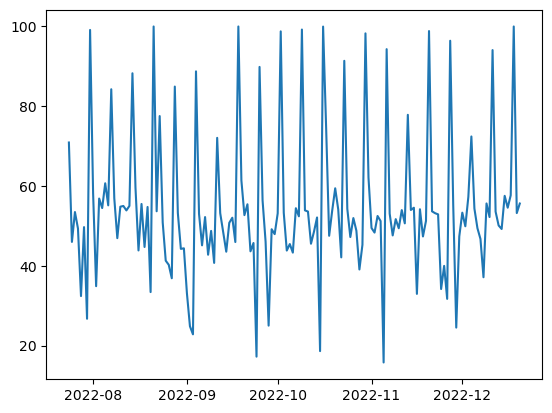

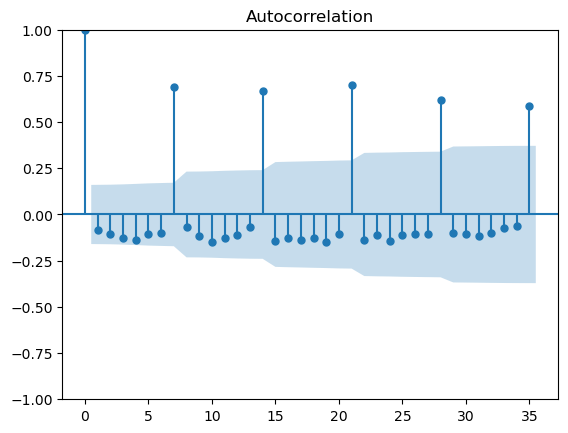

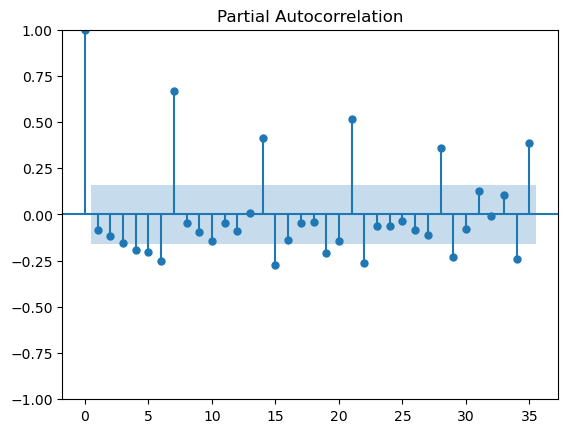

In [18]:
itemid = random.choice(np.array(df_last3M.loc[~df_last3M["period"].isna()]["itemid"]))
df_thisItem = df_last3M.loc[df_last3M["itemid"]==itemid]

print(f"""This item has period {df_thisItem["period"].unique()[0]}""")
plt.plot(df_thisItem["clock"], df_thisItem["value_max"])
plot_acf(df_thisItem["value_max"], lags=35)
plot_pacf(df_thisItem["value_max"], lags=35);